# My Daily Use of my iPhone via Screen Time
## By Sarah Hagen
### CPSC 222, Fall 2020

_Websites used:_
* [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)
* [Pandas Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html)
* [Matplotlib](https://matplotlib.org/)
* [SciPy stats](https://docs.scipy.org/doc/scipy/reference/stats.html)
* [Stackoverflow date formatting - python](https://stackoverflow.com/questions/14524322/how-to-convert-a-date-string-to-different-format)
* [Python's datetime module](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes)
* [Pretty print for JSON objects](https://jsonformatter.org/json-pretty-print)
* [Astronomy API](https://ipgeolocation.io/documentation/astronomy-api.html)
* [Latitude and Longitude from an address](https://www.latlong.net/convert-address-to-lat-long.html)
* [Latex symbols](https://oeis.org/wiki/List_of_LaTeX_mathematical_symbols)
* [What Defines a Short Day](https://www.collinsdictionary.com/us/dictionary/english/short-day)
* [Scikit-Learn  - Machine Learning classifiers](https://scikit-learn.org/stable/)

_Other sources:_
* Apple - Screen Time
* Dr. Gina Sprint's CPSC 222 Course

In [1]:
import utils
import pandas as pd
import datetime
import json
import requests
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

## Introduction
The domain of my project is the device use domain. The data in in the table is being collected through Apple as an iOS tool. I am researching how much time I spend on certain categories on my phone (the top 3 categories) and my daily use of my iPhone.  
This domain is important to me because I am constantly using my phone and by getting data on how much time I spend on certain applications in my phone may help me to understand why I spend a lot of time using my phone or startle me enough to try to limit my screen time.  
I am researching how much time I spend on certain applications on my phone and my daily use of social media. The dataset involves several attributes either in minutes or the count:
* Social networking
* Entertainment
* Productivity
* Creativity
* Reading and reference
* Pickups
* Notifications
* Screen time

Some hypotheses I have with this domain are that:
* On average, I spend more time with entertainment on my device than I do on social media
* On average, I spend 2.5 hours (aka 150 minutes) on social media
* On average, I spend less than 3 hours (aka 180 minutes) on entertainment
* My average pickup count is equal to my average notification count
* My average screen time is greater 4 hours (aka 240 minutes)
* On average, I spend the same amount of time on my phone as an average short length day

My findings:
* I spend more time on social media (over 2 hours and 30 minutes) than I originally thought (around 2 hours and 30 minutes)
* I spend more time on my phone (over 4 hours) than I originally thought (less than 4 hours)
* I spend an equal amount of time on my phone as an average short day (less than 10 hours)

The classification task I implemented was social networking. My best classification results were 93% accuracy using the decision tree classifier.

## Data Analysis
Format for tables:
* Screen time table is a CSV file
* Length of day table is a JSON file

The details within the dataset that I use:
* Social networking attribute is the social media applications like Snapchat, Instagram, and Facebook, I use on my phone.
* Entertainment attribute is the applications for television shows and movies (like Netflix or YouTube), music like Apple Music, and games.
* Productivity attribute is the applications for school and other such subjects.
* Other attribute is the applications that have no specific category like notes.
* Creativity attribute is the applications that are more on the creative side like cameras and photos.
* Reading and reference attribute is the applications that are book-like, for example news websites like BBC News.
* Pickups attribute is the number of times the phone is explicity used.
* Notifications attribute is how many notifications I receive on my phone, regardless of how it is displayed.
* Screen time attribute is how long I spent on my phone for the day.
* Less Used attribute is the difference between the screen time attribute and the total of minutes of screen time.
* Length of day is how long daylight lasted, aka the time from sunrise to sunset.

The data preparation I completed:
* Inputting "0" for the categories that were not in the top 3 for the day via manually inputting the data in the screen_time_data.csv

The data preparation I will need to do is:
* adding a column to the DataFrame called "Less Used(in minutes)" and add the other minutes that were not in the top 3 categories

For the second table, I will be using an API called "Astronomy API" (cited above).  
The details within the dataset that I will be using is the length of day:
* length of day attribute is how long daylight lasted
The data preparation I will need to do is:
* parsing through the JSON file to get the length of the day
* adding those attributes to a new CSV file along with the date associated
* merging the length of the day CSV file with the screen time CSV file by date

### Data Preparation
Calculating the difference in Top 3 and Not Top 3 categories for each day. Inputting the calculated minutes into the DataFrame.

In [2]:
screen_time_data_df = utils.load_csv_file("screen_time_data.csv")
top_3_row_total = []
not_top_3_col = []

for index in range(len(screen_time_data_df)):
    row_df = screen_time_data_df.iloc[index:index + 1]
    row_nums_ser = row_df[["Social Networking(in minutes)", "Entertainment(in minutes)",
       "Productivity(in minutes)", "Other(in minutes)",
       "Creativity(in minutes)", "Reading and Reference(in minutes)"]].sum()
    row_total = row_nums_ser.sum()
    top_3_row_total.append(row_total)

total_screen_time_ser = screen_time_data_df["Screen Time(in minutes)"]
for index in range(len(top_3_row_total)):
    total_screen_time = int(total_screen_time_ser.iloc[index:index + 1])
    not_top_3_col.append(total_screen_time - int(top_3_row_total[index]))

screen_time_data_df["Less Used(in minutes)"] = not_top_3_col

Fixing the format of the Dates index for the API.

In [3]:
# creating a list of dates in format 'YYYY-MM-DD' for the API
api_dates = []

# fixing date in screen time dataset
for date in screen_time_data_df.index:
    new_date = datetime.datetime.strptime(date, "%m/%d/%Y").strftime("%Y-%m-%d")
    api_dates.append(new_date)

Inputting new dates into the API.

For the second table:
* Latitude for the API: 47.854359
* Longitude for the API: -122.332397

In [4]:
latitude = str(47.854359)
longitude = str(-122.332397)
urls = []
day_lengths = []

# creating the urls for the API
for formatted_date in api_dates:
    url = "https://api.ipgeolocation.io/astronomy"
    # adding parameters
    url += "?apiKey=446bccee92ea4b81aeec7257706651fe"
    url += "&lat=" + latitude
    url += "&long=" + longitude
    url += "&date=" + formatted_date # format = YYYY-MM-DD
    urls.append(url)

# parsing through the object to get day_length
for url in urls:
    response = requests.get(url=url)
    json_object = json.loads(response.text)
    day_lengths.append(json_object["day_length"])

Converting the format from hours:minutes to minutes

In [5]:
day_lengths_mins = []

for time in day_lengths:
    minutes = (int(time[:2]) * 60) + int(time[3:5])
    day_lengths_mins.append(minutes)

Creating a DataFrame for the list of the length of the days and then putting it into a CSV file

In [6]:
day_lengths_df = pd.DataFrame(day_lengths_mins, index=screen_time_data_df.index, columns=["Length of Day"])
day_lengths_df.to_csv("day_lengths.csv")

Merging the length of the day with "Date"

In [7]:
screen_time_df = utils.join("Date", screen_time_data_df, day_lengths_df)

### Exploratory Data Analysis
The data aggregation techniques I am going to apply are the sum, mean, standard deviation, minimum/maximum, median, and the range on each attribute.

In [8]:
social_networking_ser = utils.column_slicing("Social Networking(in minutes)", screen_time_df)
social_networking_total, social_networking_avg, social_networking_std_dev, social_networking_smallest_rounded, social_networking_largest_rounded, social_networking_median_rounded = utils.compute_stats(social_networking_ser)

entertainment_ser = utils.column_slicing("Entertainment(in minutes)", screen_time_df)
entertainment_total, entertainment_avg, entertainment_std_dev, entertainment_smallest_rounded, entertainment_largest_rounded, entertainment_median_rounded = utils.compute_stats(entertainment_ser)

productivity_ser = utils.column_slicing("Productivity(in minutes)", screen_time_df)
productivity_total, productivity_avg, productivity_std_dev, productivity_smallest_rounded, productivity_largest_rounded, productivity_median_rounded = utils.compute_stats(productivity_ser)

other_ser = utils.column_slicing("Other(in minutes)", screen_time_df)
other_total, other_avg, other_std_dev, other_smallest_rounded, other_largest_rounded, other_median_rounded = utils.compute_stats(other_ser)

creativity_ser = utils.column_slicing("Creativity(in minutes)", screen_time_df)
creativity_total, creativity_avg, creativity_std_dev, creativity_smallest_rounded, creativity_largest_rounded, creativity_median_rounded = utils.compute_stats(creativity_ser)

reading_reference_ser = utils.column_slicing("Reading and Reference(in minutes)", screen_time_df)
reading_reference_total, reading_reference_avg, reading_reference_std_dev, reading_reference_smallest_rounded, reading_reference_largest_rounded, reading_reference_median_rounded = utils.compute_stats(reading_reference_ser)

pickups_ser = utils.column_slicing("Pickups", screen_time_df)
pickups_total, pickups_avg, pickups_std_dev, pickups_smallest_rounded, pickups_largest_rounded, pickups_median_rounded = utils.compute_stats(pickups_ser)

notifications_ser = utils.column_slicing("Notifications", screen_time_df)
notifications_total, notifications_avg, notifications_std_dev, notifications_smallest_rounded, notifications_largest_rounded, notifications_median_rounded = utils.compute_stats(notifications_ser)

screen_time_total, screen_time_avg, screen_time_std_dev, screen_time_smallest_rounded, screen_time_largest_rounded, screen_time_median_rounded = utils.compute_stats(total_screen_time_ser)

Displaying the results

In [9]:
# social networking
utils.print_stats_minutes("Social Networking", social_networking_total, social_networking_avg, social_networking_std_dev, social_networking_smallest_rounded, social_networking_largest_rounded, social_networking_median_rounded)
print()

# entertainment
utils.print_stats_minutes("Entertainment", entertainment_total, entertainment_avg, entertainment_std_dev, entertainment_smallest_rounded, entertainment_largest_rounded, entertainment_median_rounded)
print()

# productivity
utils.print_stats_minutes("Productivity", productivity_total, productivity_avg, productivity_std_dev, productivity_smallest_rounded, productivity_largest_rounded, productivity_median_rounded)
print()

# other
utils.print_stats_minutes("Other", other_total, other_avg, other_std_dev, other_smallest_rounded, other_largest_rounded, other_median_rounded)
print()

# creativity
utils.print_stats_minutes("Creativity", creativity_total, creativity_avg, creativity_std_dev, creativity_smallest_rounded, creativity_largest_rounded, creativity_median_rounded)
print()

# reading and reference
utils.print_stats_minutes("Reading and Reference", reading_reference_total, reading_reference_avg, reading_reference_std_dev, reading_reference_smallest_rounded, reading_reference_largest_rounded, reading_reference_median_rounded)
print()

# pickups
utils.print_stats_times("Pickups", pickups_total, pickups_avg, pickups_std_dev, pickups_smallest_rounded, pickups_largest_rounded, pickups_median_rounded)
print()

# notifications
utils.print_stats_times("Notifications", notifications_total, notifications_avg, notifications_std_dev, notifications_smallest_rounded, notifications_largest_rounded, notifications_median_rounded)
print()

# screen time total
utils.print_stats_minutes("Total Screen Time", screen_time_total, screen_time_avg, screen_time_std_dev, screen_time_smallest_rounded, screen_time_largest_rounded, screen_time_median_rounded)

Social Networking Total: 11218 minutes
Social Networking Average: 158.0 minutes
Social Networking Standard Deviation: 56.92426045695656 minutes
Social Networking Least: 37 minutes
Social Networking Most: 305 minutes
Social Networking Median: 152.0 minutes
Social Networking Range: 268 minutes

Entertainment Total: 3031 minutes
Entertainment Average: 42.690140845070424 minutes
Entertainment Standard Deviation: 53.18528033455868 minutes
Entertainment Least: 0 minutes
Entertainment Most: 268 minutes
Entertainment Median: 33.0 minutes
Entertainment Range: 268 minutes

Productivity Total: 596 minutes
Productivity Average: 8.394366197183098 minutes
Productivity Standard Deviation: 13.334679677163422 minutes
Productivity Least: 0 minutes
Productivity Most: 51 minutes
Productivity Median: 0.0 minutes
Productivity Range: 51 minutes

Other Total: 597 minutes
Other Average: 8.408450704225352 minutes
Other Standard Deviation: 14.611714932877602 minutes
Other Least: 0 minutes
Other Most: 57 minutes


For the total screen time, I generally spend 305 minutes (aka 5 hours and 5 minutes) on my phone with a range of 277 minutes (aka 4 hours and 37 minutes). My lowest time was 162 minutes (aka 2 hours and 42 minutes). My highest time was 439 minutes (aka 7 hours and 19 minutes). The median was 312 minutes (aka 5 hours and 12 minutes).

Below (the visualizations and summaries for the rest of the attributes)

#### Visualizations
The visualizations that will informatively present the attributes and relationships are bar charts, pie charts, histograms, and line plots.  
* For social networking, entertainment, productivity, creativity, reading and reference, pickups, and notifications. I will use a histogram
* For social networking, entertainment, productivity, creativity, reading and reference, pickups, and notifications. I will use a line plot
* All of them combined, I will use a pie chart
* Comparing the top 3 categories for the day to the not in the top 3 categories using a scatter plot

For social networking, entertainment, productivity, creativity, reading and reference, pickups, and notifications. I will use a histogram

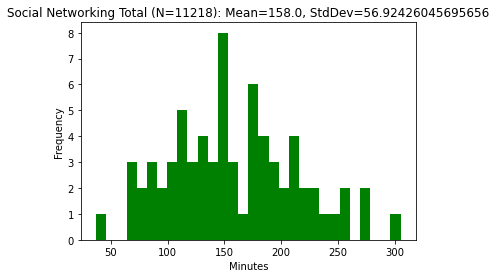

In [10]:
# for the social networking attribute
utils.histogram(social_networking_ser, "Social Networking", social_networking_total, social_networking_avg, social_networking_std_dev, "Minutes")

Above: This graph represents how many times the minutes were in the dataset. This particular graph illustrates that I spent a maximum of 8 times using social media for about 150 minutes (aka 2 hours and 30 minutes). My lowest was 1 time for about 45 minutes and 300 minutes (aka 5 hours). My average time spent on social media was about 158 minutes (aka 2 hours and 38 minutes). "N" represents the total number of minutes spent on social networking applications.

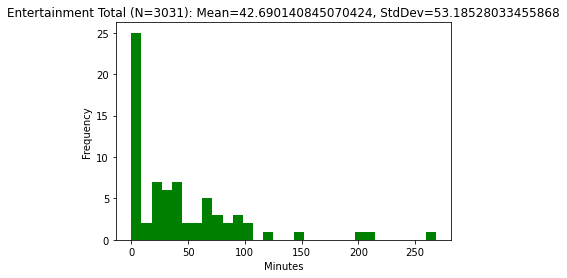

In [11]:
# for the entertainment attribute
utils.histogram(entertainment_ser, "Entertainment", entertainment_total, entertainment_avg, entertainment_std_dev, "Minutes")

Above: This graph represents how many times the minutes were in the dataset. This particular graph illustrates that I spent a maximum of about 30 times using the entertainment applications for between 0 and 5 minutes. My lowest was about 1 time between 120 minutes (aka 2 hours) to 265 minutes (aka 4 hours and 25 minutes). My average time spent on entertainment was about 4 minutes. "N" represents the total number of minutes spent on entertainment applications.

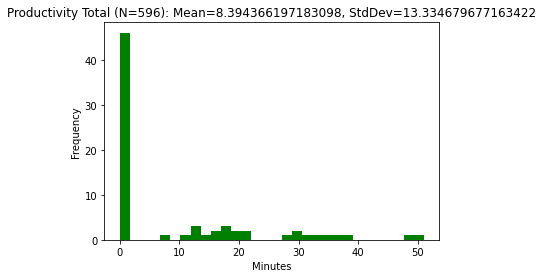

In [12]:
# for the productivity attribute
utils.histogram(productivity_ser, "Productivity", productivity_total, productivity_avg, productivity_std_dev, "Minutes")

Above: This graph represents how many times the minutes were in the dataset. This particular graph illustrates that I spent a maximum of about 48 times using the productivity applications for between 0 and 5 minutes. My lowest was less than 5 times between 8 minutes and 52 minutes. My average time spent on productivity applications was about 8 minutes. "N" represents the total number of minutes spent on productivity applications.

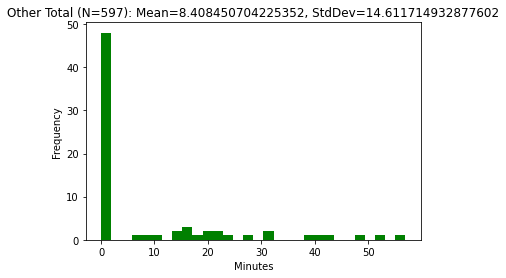

In [13]:
# for the other attribute
utils.histogram(other_ser, "Other", other_total, other_avg, other_std_dev, "Minutes")

Above: This graph represents how many times the minutes were in the dataset. This particular graph illustrates that I spent a maximum of about 48 times using the other category for between 0 and 5 minutes. My lowest was less than 5 times between 5 minutes and 57 minutes. My average time spent on the other category was about 8 minutes. "N" represents the total number of minutes spent on other applications.

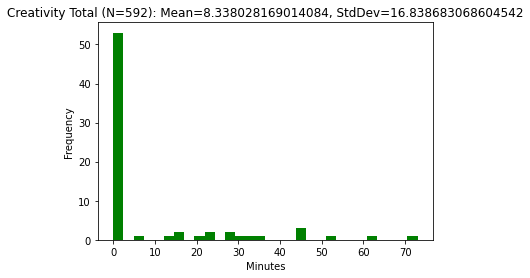

In [14]:
# for the creativity attribute
utils.histogram(creativity_ser, "Creativity", creativity_total, creativity_avg, creativity_std_dev, "Minutes")

Above: This graph represents how many times the minutes were in the dataset. This particular graph illustrates that I spent a maximum of about 52 times using the creativity applications for between 0 and 5 minutes. My lowest was less than 5 times between 9 minutes and 65 minutes (aka 1 hour and 5 minutes). My average time spent on the creativity applications was about 8 minutes. "N" represents the total number of minutes spent on creativity applications.

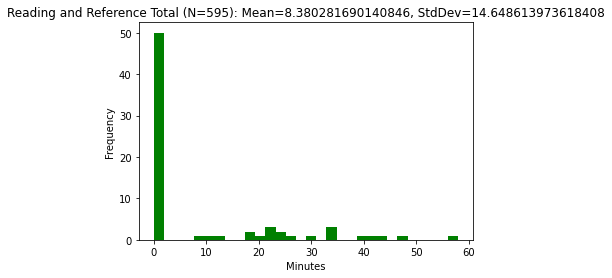

In [15]:
# for the reading and reference networking attribute
utils.histogram(reading_reference_ser, "Reading and Reference", reading_reference_total, reading_reference_avg, reading_reference_std_dev, "Minutes")

Above: This graph represents how many times the minutes were in the dataset. This particular graph illustrates that I spent a maximum of about 50 times using the reading and reference applications for between 0 and 5 minutes. My lowest was less than 5 times between 10 minutes and 58 minutes. My average time spent on reading and reference applications was about 8 minutes. "N" represents the total number of minutes spent on reading and reference applications.

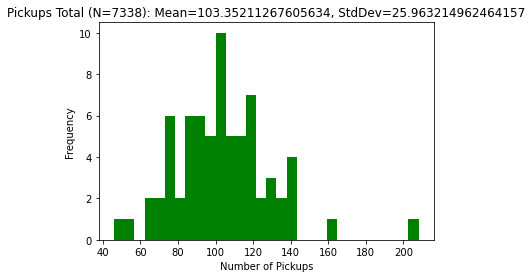

In [16]:
# for the pickups attribute
utils.histogram(pickups_ser, "Pickups", pickups_total, pickups_avg, pickups_std_dev, "Number of Pickups")

Above: This graph represents how many times I indirectly or directly, either unlocked my iPhone or directly used it in the dataset. This particular graph illustrates that I spent a maximum of about 10 times using my iPhone for at least 105 times. My lowest was about 1 time for about 48-58, 161-167, and 205-210 times. My average time spent on using my device was about 103 times. "N" represents the total number of times I spent using my iPhone.

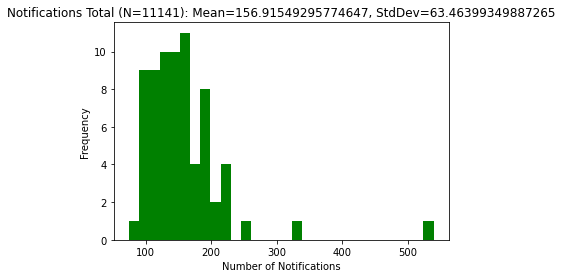

In [17]:
# for the notifications attribute
utils.histogram(notifications_ser, "Notifications", notifications_total, notifications_avg, notifications_std_dev, "Number of Notifications")

Above: This graph represents how many times I received a notification on my iPhone in the dataset. This particular graph illustrates that I received a maximum of about 175 notifications for about 11 times. My lowest was about 1 time for about 50-97, 201-210, 250, 330, and 550 notifications. My average number of notifications was about 157. "N" represents the total number of notifcations I received.

Below: For social networking, entertainment, productivity, creativity, reading and reference, pickups, and notifications. I will use a line plot

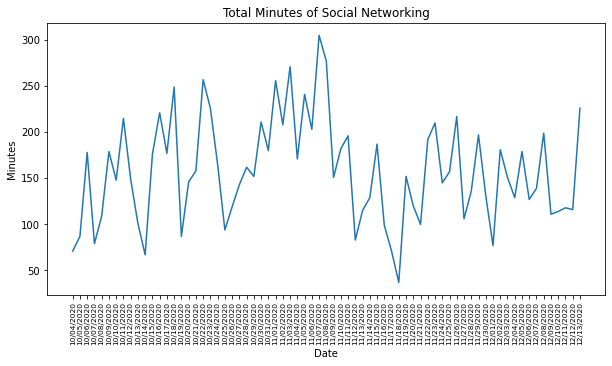

In [18]:
# for the social networking attribute
utils.line_plot(screen_time_df.index, social_networking_ser, "Minutes", "Social Networking")

Above: This graph represents the total minutes I spent on social networking applications from October 04, 2020 to December 13, 2020. The lowest date I spent on social networking was December 18, 2020 for 37 minutes. The highest date I spent on social networking was on November 07, 2020 for 305 minutes (aka 5 hours and 5 minutes). Overtime, I balance my time with social networking.

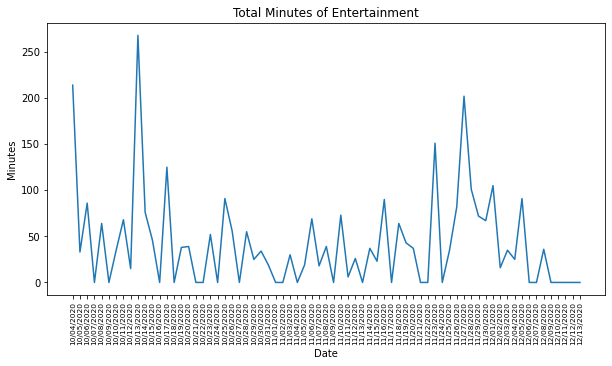

In [19]:
# for the entertainment attribute
utils.line_plot(screen_time_df.index, entertainment_ser, "Minutes", "Entertainment")

Above: This graph represents the total minutes I spent on entertainment applications from October 04, 2020 to December 13, 2020. The lowest date I spent on entertainment were several days where I did not spend enough time on it for it to be considered the Top 3 for the day, so 0 minutes. The highest date I spent on entertainment was October 13, 2020 for 268 minutes (aka 4 hours and 28 minutes). Overtime, I balance my time with entertainment, and generally do not spend more than 150 minutes with a few spikes.

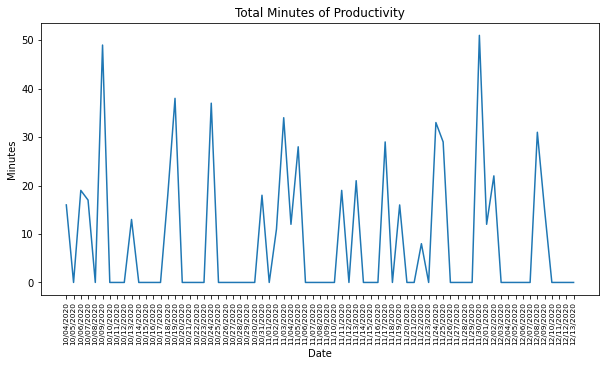

In [20]:
# for the productivity attribute
utils.line_plot(screen_time_df.index, productivity_ser, "Minutes", "Productivity")

Above: This graph represents the total minutes I spent on productivity applications from October 04, 2020 to December 13, 2020. The lowest date I spent on productivity applications were several days where I did not spend enough time on it for it to be considered the Top 3 for the day, so 0 minutes. The highest date I spent on productivity applications was November 30, 2020 for 51 minutes. Overtime, I usually either use it for a long period of time or I do not.

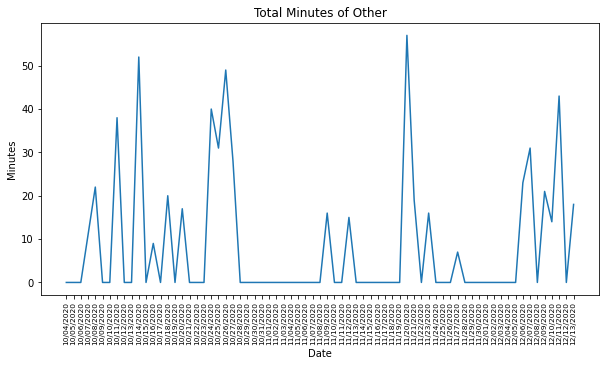

In [21]:
# for the other attribute
utils.line_plot(screen_time_df.index, other_ser, "Minutes", "Other")

Above: This graph represents the total minutes I spent on the other category from October 04, 2020 to December 13, 2020. The lowest date I spent on the other category were several days where I did not spend enough time on it for it to be considered the Top 3 for the day, so 0 minutes. The highest date I spent on productivity applications was November 20, 2020 for 57 minutes. Overtime, I usually either use it for a long period of time or I do not.

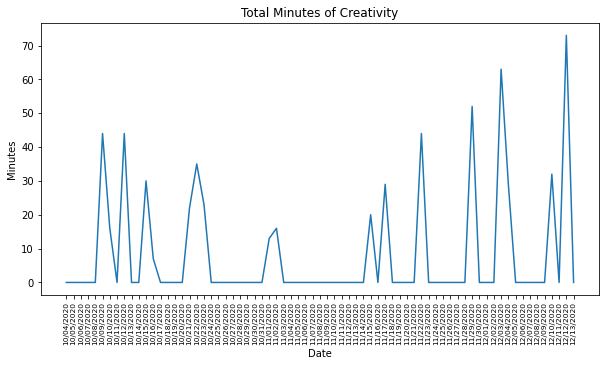

In [22]:
# for the creativity attribute
utils.line_plot(screen_time_df.index, creativity_ser, "Minutes", "Creativity")

Above: This graph represents the total minutes I spent on creativity applications from October 04, 2020 to December 13, 2020. The lowest date I spent on productivity applications were several days where I did not spend enough time on it for it to be considered the Top 3 for the day, so 0 minutes. The highest date I spent on creativity applications was December 12, 2020 for 73 minutes (aka 1 hour and 13 minutes). Overtime, I usually either use it for a long period of time or I do not.

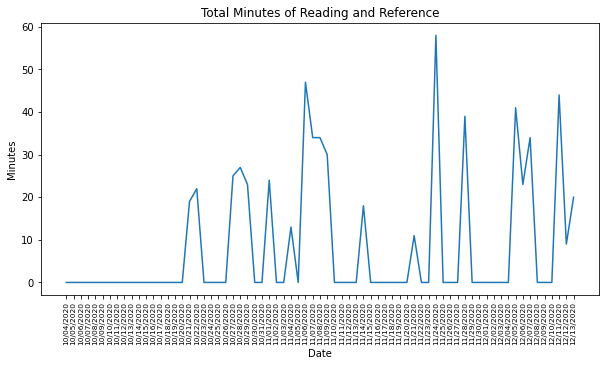

In [23]:
# for the reading and reference attribute
utils.line_plot(screen_time_df.index, reading_reference_ser, "Minutes", "Reading and Reference")

Above: This graph represents the total minutes I spent on reading and reference applications from October 04, 2020 to December 13, 2020. The lowest date I spent on productivity applications were several days where I did not spend enough time on it for it to be considered the Top 3 for the day, so 0 minutes. The highest date I spent on productivity applications was November 24, 2020 for 58 minutes. Overtime, I usually either use it for a long period of time or I do not.

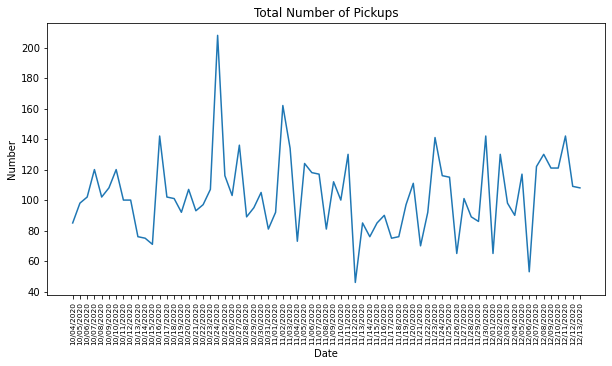

In [24]:
# for the pickups attribute
utils.line_plot(screen_time_df.index, pickups_ser, "Number", "Pickups")

Above: This graph represents the total number of pickups from October 04, 2020 to December 13, 2020. The lowest date I spent picking up my phone was November 12, 2020 for a total of 46 pickups. The highest date I spent picking up my phone was October 24, 2020 for a total of 208 pickups. Overtime, I usually either use my phone often or I do not.

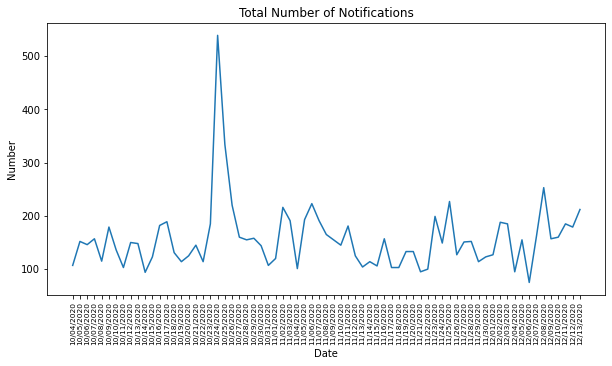

In [25]:
# for the notifications attribute
utils.line_plot(screen_time_df.index, notifications_ser, "Number", "Notifications")

Above: This graph represents the total number of notifications from October 04, 2020 to December 13, 2020. The lowest date I received notifications on my phone was December 06, 2020 for a total of 75 notifications. The highest date I received notifications on my phone was October 24, 2020 for a total of 539 notifications. Overtime, I usually receive less than 300 notifications on my phone.

Below: All of them combined, I will use a pie chart

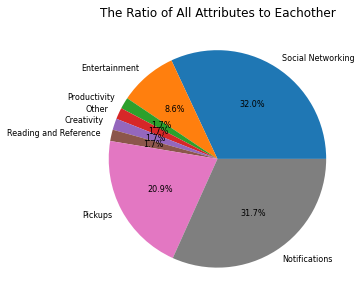

In [26]:
utils.pie_chart([social_networking_total, entertainment_total, productivity_total, other_total, creativity_total, reading_reference_total, pickups_total, notifications_total])

Above: This pie chart represents the percent of each category compared to the other categories from October 04, 2020 to December 13, 2020. My most used category was social networking by 0.3%. Productivity, other, creativity, and reading and reference make up less than 7% of the chart and are less than entertainment (8.6%). My pickups and notifications make up majority of the pie at a total of 52.6%.

Below: Comparing the top 3 categories for the day to the not in the top 3 categories using a scatter plot

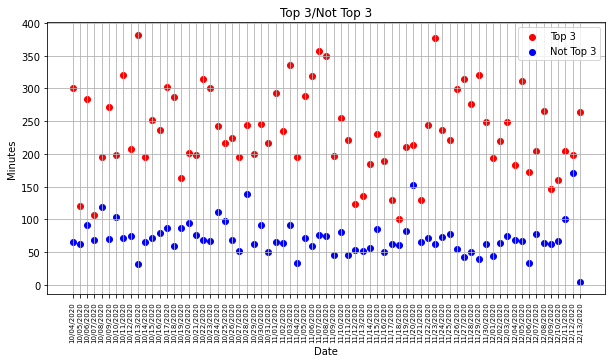

In [27]:
plt.figure(figsize=[10.0, 5.0])
plt.scatter(screen_time_df.index, top_3_row_total, color="red", label="Top 3")
plt.scatter(screen_time_df.index, not_top_3_col, color="blue", label="Not Top 3")
plt.title("Top 3/Not Top 3")
plt.xlabel("Date")
plt.ylabel("Minutes")
plt.xticks(rotation=90, horizontalalignment="center", fontsize=7)
plt.grid()
plt.legend()
plt.show()

The top three categories compared to the categories that did not get top three for the day (excluding pickups and notifications because they are their own categories) were higher than 100 minutes while not top three were generally lower than 125 minutes. The total for top three were always higher than categories not in the top three, respectively, for each day.

### Statistical Analysis
The hypotheses that I will test are:
1. On average, I spend more time with entertainment on my device than I do on social media
1. On average, I spend 2.5 hours (aka 150 minutes) on social media
1. On average, I spend less than 3 hours (aka 180 minutes) on entertainment
1. My average pickup count is equal to my average notification count
1. My average screen time is greater 4 hours (aka 240 minutes)
1. On average, I spend the same amount of time on my phone as an average short length day

#### 1. On average, I spend more time with entertainment on my device than I do on social media.
**5 Step Hypothesis Testing Approach**:  
1. State Null and Alternative Hypothesis  
$H_{0}$: $\mu1\leq\mu2$  
$H_{1}$: $\mu1>\mu2$

1. Select the Level of Significance  
$\alpha$ = $0.05$

1. Select the appropriate test statistic  
$t=\frac{\overline{d}-\mu_{d}}{S_\overline{d}}$

1. Formulate the Decision Rule  
$df$ = $n-1$ = $71-1$ = $70$ = $60$  
$df$ is calculated differently in a two-sample test than a one-sample test.  
Since the length of the dataset is closest to 60, the $df$ is declared as $60$  
$\alpha$ = $0.05$  
one-tailed test  
_used t-table to calculate t_  
$t$(critical) = $1.671$  
Decision Rule:
   * if t-computed is $>$ +1.671 then Reject $H_{0}$
   * if t-computed is $\leq$ +1.671 then Do Not Reject $H_{0}$

1. Make a Decision

In [28]:
alpha = 0.05
t_computed, p_value = stats.ttest_rel(entertainment_ser, social_networking_ser)
print("t-computed:", t_computed, ", p-value:", p_value / 2)
if p_value / 2 > alpha:
    print("Reject H0, p-value:", p_value / 2)
else:
    print("Do Not Reject H0, p-value:", p_value / 2)

t-computed: -11.267314737004977 , p-value: 1.108388451886812e-17
Do Not Reject H0, p-value: 1.108388451886812e-17


The above code cell calculated t-computed to be -11.267, so  
Since t-computed (-11.267) is $<$ t-critical (+1.671):
* Do Not Reject $H_{0}$  
* Succeed to Reject $H_{1}$  
* $\mu1\leq\mu2$  

In conclusion, the mean duration for social media use is greater or equal to the mean duration for entertainment use.

#### 2. On average, I spend 2.5 hours (aka 150 minutes) on social media.
**5 Step Hypothesis Testing Approach**:  
1. State Null and Alternative Hypothesis  
$H_{0}$: $\mu\neq150$  
$H_{1}$: $\mu=150$

1. Select the Level of Significance  
$\alpha$ = $0.05$

1. Select the appropriate test statistic  
$t=\frac{\overline{x}-\mu}{s/\sqrt{n}}$

1. Formulate the Decision Rule  
$df$ = $n-1$ = $71-1$ = $70$ = $60$  
Since the length of the dataset is closest to 60, the $df$ is declared as $60$  
$\alpha$ = $0.05$  
two-tailed test  
_used t-table to calculate t_  
$t$(critical) = $2.000$  
Decision Rule:
   * if t-computed $<$ -2.000 or $>$ +2.000 then Reject $H_{0}$
   * if t-computed $\geq$ -2.000 and $\leq$ +2.000 then Do Not Reject $H_{0}$

1. Make a Decision  

In [29]:
alpha = 0.05
t_computed, p_value = stats.ttest_1samp(social_networking_ser, 150)
print("t-computed:", t_computed, ", p-value:", p_value)
if p_value < alpha:
    print("Reject H0, p-value:", p_value)
else:
    print("Do Not Reject H0, p-value:", p_value)

t-computed: 1.1841910223213619 , p-value: 0.24034290504620132
Do Not Reject H0, p-value: 0.24034290504620132


The above code cell calculated t-computed to be 1.184, so  
Since t-computed (1.184) is $<$ t-critical (+2.000) and $>$ t-critical (-2.000):
* Do Not Reject $H_{0}$  
* Succeed to Reject $H_{1}$  
* $\mu\neq150$

In conclusion, I do not spend an average of 2 hours and 30 minutes (150 minutes) on social media.

#### 3. On average, I spend less than 3 hours (aka 180 minutes) on entertainment
**5 Step Hypothesis Testing Approach**:  
1. State Null and Alternative Hypothesis  
$H_{0}$: $\mu\geq180$  
$H_{1}$: $\mu<180$

1. Select the Level of Significance  
$\alpha$ = $0.05$

1. Select the appropriate test statistic  
$t=\frac{\overline{x}-\mu}{s/\sqrt{n}}$

1. Formulate the Decision Rule  
$df$ = $n-1$ = $71-1$ = $70$ = $60$  
Since the length of the dataset is closest to 60, the $df$ is declared as $60$  
$\alpha$ = $0.05$  
one-tailed test  
_used t-table to calculate t_  
$t$(critical) = $1.671$  
Decision Rule:
   * if t-computed $<$ -1.671 then Reject $H_{0}$
   * if t-computed $\geq$ -1.671 then Do Not Reject $H_{0}$

1. Make a Decision  

In [30]:
alpha = 0.05
t_computed, p_value = stats.ttest_1samp(entertainment_ser, 180)
print("t-computed:", t_computed, ", p-value:", p_value / 2)
if p_value < alpha:
    print("Reject H0, p-value:", p_value / 2)
else:
    print("Do Not Reject H0, p-value:", p_value / 2)

t-computed: -21.754015985159672 , p-value: 3.628073192978399e-33
Reject H0, p-value: 3.628073192978399e-33


The above code cell calculated t-computed to be -21.754, so  
Since t-computed (-21.754) is $<$ t-critical (-1.171):
* Reject $H_{0}$  
* Fail to Reject $H_{1}$  
* $\mu<180$

In conclusion, the mean duration for entertainment use is less than 3 hours (180 minutes).

#### 4. My average pickup count is equal to my average notification count.
**5 Step Hypothesis Testing Approach**:  
1. State Null and Alternative Hypothesis  
$H_{0}$: $\mu1\neq\mu2$  
$H_{1}$: $\mu1=\mu2$

1. Select the Level of Significance  
$\alpha$ = $0.05$

1. Select the appropriate test statistic  
$t=\frac{\overline{d}-\mu_{d}}{S_\overline{d}}$

1. Formulate the Decision Rule  
$df$ = $n-1$ = $71-1$ = $70$ = $60$  
$df$ is calculated differently in a two-sample test than a one-sample test.  
Since the length of the dataset is closest to 60, the $df$ is declared as $60$  
$\alpha$ = $0.05$  
two-tailed test  
_used t-table to calculate t_  
$t$(critical) = $2.000$  
Decision Rule:
   * if t-computed $<$ -2.000 or $>$ +2.000 then Reject $H_{0}$
   * if t-computed $\geq$ -2.000 and $\leq$ +2.000 then Do Not Reject $H_{0}$ 

1. Make a Decision

In [31]:
alpha = 0.05
t_computed, p_value = stats.ttest_rel(pickups_ser, notifications_ser)
print("t-computed:", t_computed, ", p-value:", p_value)
if p_value < alpha:
    print("Reject H0, p-value:", p_value)
else:
    print("Do Not Reject H0, p-value:", p_value)

t-computed: -9.357812499748428 , p-value: 5.857193991054223e-14
Reject H0, p-value: 5.857193991054223e-14


The above code cell calculated t-computed to be -9.358, so  
Since t-computed (-9.358) is $<$ t-critical (-2.000):
* Reject $H_{0}$  
* Fail to Reject $H_{1}$  
* $\mu1=\mu2$

In conclusion, my average pickup count is equal to my average notification count.

#### 5. My average screen time is greater 4 hours (aka 240 minutes)
**5 Step Hypothesis Testing Approach**:  
1. State Null and Alternative Hypothesis  
$H_{0}$: $\mu\leq240$  
$H_{1}$: $\mu>240$

1. Select the Level of Significance  
$\alpha$ = $0.05$

1. Select the appropriate test statistic  
$t=\frac{\overline{x}-\mu}{s/\sqrt{n}}$

1. Formulate the Decision Rule  
$df$ = $n-1$ = $71-1$ = $70$ = $60$  
Since the length of the dataset is closest to 60, the $df$ is declared as $60$  
$\alpha$ = $0.05$  
one-tailed test  
_used t-table to calculate t_  
$t$(critical) = $1.671$  
Decision Rule:
   * if t-computed $>$ +1.671 then Reject $H_{0}$
   * if t-computed $\leq$ +1.671 then Do Not Reject $H_{0}$

1. Make a Decision  

In [32]:
alpha = 0.05
t_computed, p_value = stats.ttest_1samp(total_screen_time_ser, 240)
print("t-computed:", t_computed, ", p-value:", p_value / 2)
if p_value / 2 < alpha:
    print("Reject H0, p-value:", p_value / 2)
else:
    print("Do Not Reject H0, p-value:", p_value / 2)

t-computed: 8.010295175564579 , p-value: 8.7438709016496e-12
Reject H0, p-value: 8.7438709016496e-12


The above code cell calculated t-computed to be 8.010, so  
Since t-computed (8.010) is $>$ t-critical (+1.671):
* Reject $H_{0}$  
* Fail to Reject $H_{1}$  
* $\mu>240$

In conclusion, the mean duration for my total screen time use is greater than 4 hours (240 minutes).

#### 6. On average, I spend the same amount of time on my phone as an average short length day
**5 Step Hypothesis Testing Approach**:  
1. State Null and Alternative Hypothesis  
$H_{0}$: $\mu1\neq\mu2$  
$H_{1}$: $\mu1=\mu2$  
 
1. Select the Level of Significance  
$\alpha$ = $0.05$  
  
1. Select the appropriate test statistic  
$t=\frac{\overline{X_1}-\overline{X_2}}{\sqrt{s_p^2(\frac{1}{n_1}+\frac{1}{n_2})}}$  
  
1. Formulate the Decision Rule

In [33]:
# putting the shorter days in another list called "short_days"
# short day = less than 12 hours (link above) aka 11 hours and 59 minutes (719 minutes) but I will be doing less than 10 hours (600 minutes)
short_days = []
for day in day_lengths_mins:
    if day < 600:
        short_days.append(day)

# getting the length of the day_lengths_mins list
print("Short Days Length:", len(short_days))

Short Days Length: 44


$df$ = $n_{1}+n_{2}-2$ = $71+44-2$ = $115-2$ = $113$ = $120$   
Since the length of the dataset is closest to 120, the $df$ is declared as $120$  
$\alpha$ = $0.05$  
two-tailed test  
_used t-table to calculate t_  
$t$(critical) = $1.980$  
Decision Rule:
   * if t-computed $<$ -1.980 or $>$ +1.980 then Reject $H_{0}$
   * if t-computed $\geq$ -1.980 and $\leq$ +1.980 then Do Not Reject $H_{0}$ 

5. Make a Decision

In [34]:
alpha = 0.05
t_computed, p_value = stats.ttest_ind(total_screen_time_ser, short_days)
print("t-computed:", t_computed, ", p-value:", p_value)
if p_value < alpha:
    print("Reject H0, p-value:", p_value)
else:
    print("Do Not Reject H0, p-value:", p_value)

t-computed: -21.81054818441847 , p-value: 2.6287325707714526e-42
Reject H0, p-value: 2.6287325707714526e-42


The above code cell calculated t-computed to be -21.814, so  
Since t-computed (-21.814) is $<$ t-critical (-1.980):
* Reject $H_{0}$  
* Fail to Reject $H_{1}$  
* $\mu1=\mu2$

In conclusion, the mean duration amount of time on my phone is the same as an average short length day.

## Classification Results

The classification approach I developed was social networking. Its performance ranged from 59-72% accuracy.  
I tested my kNN classifier's predictive ability with k Fold Cross Validation. It performed well because the classification was specific. It performed less than I expected, but adequately for how many attributes were involved.    

The preprocessing techniques I had to use were putting each date's social networking minutes into a new column with "positive" (any value lower than the median, 152) and "negative" (any value higher than the median, 152) values.

I also compared the kNN classifier to the two classifiers:
* Decision Tree
* Neural network models

Below: Creating a new column for the classification with labels "P" and "N".

In [35]:
class_labels = []

for minutes in screen_time_df["Social Networking(in minutes)"]:
    if minutes > social_networking_median_rounded:
        class_labels.append("N")
    else:
        class_labels.append("P")

Normalizing the data.  
The test instances will be:
* Entertainment: 60 minutes (1 hour)
* Productivity: 15 minutes
* Other: 11 minutes
* Creativity: 5 minutes
* Reading and Reference: 8 minutes
* Screen time: 120 minutes (2 hours)
* Less Used: 21 minutes
* Length of day: 480 mintes (8 hours)

In [36]:
instances_train = screen_time_df.drop(["Social Networking(in minutes)", "Pickups", "Notifications"], axis=1)
class_label_train = class_labels

scaler = MinMaxScaler()
scaler.fit(instances_train)
instances_training_normalized = scaler.transform(instances_train)

instances_test = [60, 15, 11, 5, 8, 120, 21, 480]
instances_test_normalized = scaler.transform([instances_test])

Using **kNN** Classification for my first approach with 7 neighbors.

In [37]:
knn_classifier = KNeighborsClassifier(n_neighbors=7, metric="euclidean")

knn_classifier.fit(instances_training_normalized, class_label_train)
class_label_predicted = knn_classifier.predict(instances_test_normalized)
print("The prediction:", class_label_predicted)

The prediction: ['P']


Testing accuracy of the prediction with k Fold Cross Validation

In [38]:
y = class_labels
X = instances_train
classification = KNeighborsClassifier(n_neighbors=7, metric="euclidean")
classification.fit(X, y)
tree_classification = DecisionTreeClassifier(random_state=0)
tree_classification.fit(X, y)

for model in [classification, tree_classification]:
    accuracies = cross_val_score(model, X, y, cv=11)
    classification_predictions = cross_val_predict(model, X, y, cv=11)
    accuracy = accuracy_score(y, classification_predictions)
    print(accuracy)

0.7183098591549296
0.5915492957746479


About 72% accuracy in classification and about 59% accuracy in tree classification

Comparing the two approaches - Decision Tree classifier and the Neural network models - to kNN classifier:
* I evaluated the performance of each classifier (except kNN classifier) by using the `.score` method of classification.
* kNN classifier and neural network models were closest with their prediction accuracy at about 59% (classification) and about 52%, respectively, and choosing the same class label.
* Neural network models was not as accurate for class label prediction compared to the kNN classifier and decision tree.
* Decision tree was more accurate in the prediction with 93% than kNN classifier, although kNN classifier was about 72% accuracy.

**Decision Tree**

In [39]:
instances_train, instances_test, class_labels_train, class_labels_test = train_test_split(X, y, random_state=0, stratify=y)

tree_classification = DecisionTreeClassifier(random_state=0)
tree_classification.fit(instances_train, class_labels_train)

# the decision tree classifies the test set
class_labels_predicted_tree = tree_classification.predict(instances_test)
print(class_labels_predicted_tree)

# the decision tree tests the accuracy
accuracy_tree = tree_classification.score(X, y)
print(accuracy_tree)

['N' 'P' 'N' 'N' 'N' 'N' 'P' 'P' 'P' 'N' 'P' 'P' 'N' 'P' 'P' 'N' 'N' 'N']
0.9295774647887324


About 93% accuracy

**Neural network models**

In [40]:
classification = MLPClassifier(solver="lbfgs", alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
classification.fit(X, y)

prediction = classification.predict(instances_test_normalized)
print("Prediction:", prediction)
accuracy = classification.score(X, y)
print("Accuracy:", accuracy)

Prediction: ['P']
Accuracy: 0.5211267605633803


About 52% accuracy

## Conclusion

I learned about my use of my screen time more than I thought I would. I learned:
* I spend a majority of my screen time on social networking.
* I usually either use my phone for a long period of time or I do not use it for very long.
* I spend a great deal of time using my phone.

The dataset I used was how many minutes I spent on my phone separated by top three for each day and a column I added on the minutes I spent not involving the top three categories. I also added a column about the length of each day to use for statistical analysis and classification.  
Within the dataset, some of the inherent challenges for classification were having to add a new column to classify the "positive" and "negative" values of the social networking column and .  
The classification approach I developed was social networking.  
Its performance ranged from 52-93% accuracy. I tested my kNN classifier's predictive ability with k Fold Cross Validation, comparing the classifier to decision tree and neural network models. It performed less than I expected, but adequately for how many attributes were involved.  
Some ideas I have on ways to improve performance are:
* to be able to have a one dimensional array for machine learning because sometimes there will only be one.
* for the kNN classifier, not have to directly input "euclidean" for the the metric, just have it be default because it may be used more than the default "minkowski".

The potential ethical impacts of my work might be:
* using my data/analysis for the companies own gain because they may claim that most young adults are on social media and their phones for several hours and they do not care about the world or others.
* the university, or a company, could look at this data/analysis and think it negatively contributes to my grades and work ethic, therefore other students' grades are suffering because of their phone use.
* other students, or people, may use my data/analysis to justify their time spent on their devices by claiming that another student/person has spent a similiar amount of time on their phone.

The stakeholders who would be interested in my results are myself, social media companies like Facebook or Snapchat, big technology companies like Apple, research doctors, and psychologists because those companies make their money through my use of their product and they could try to figure out how long I spend on each atttribute for their use. For myself, to understand how much time I use my phone and why I should use it less.